# Basic GP Regression model


The aim of this notebook is to show the different steps for creating and using a standard GP regression model:
  - reading and formatting data
  - choosing a kernel function
  - choosing a mean function
  - creating the model
  - viewing, getting and setting model parameters
  - optimising the model parameters
  - making predictions
  
We focus here on the implementation of the models in GPflow, and refer the reader to [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/) for getting more intuition on these models.
 

In [36]:
import gpflow
import numpy as np
import matplotlib
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

We denote by X and Y the input and output values:

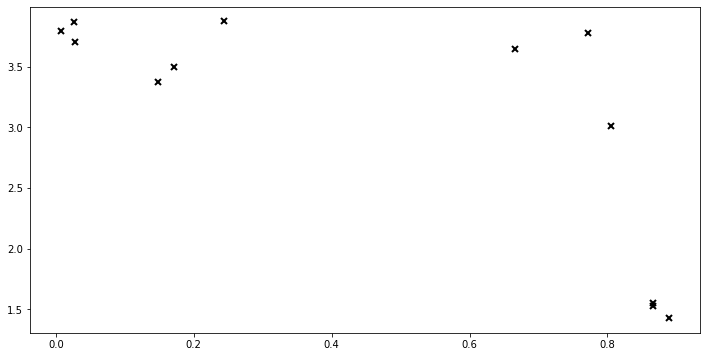

In [37]:
data = np.genfromtxt('data/regression_1D.csv', delimiter=',')
X = data[:, 0].reshape(-1, 1)
Y = data[:, 1].reshape(-1, 1)

plt.plot(X, Y, 'kx', mew=2)

Note that `X` and `Y` must be 2 dimensional np.array, with the same number of lines (one per data-point). We will consider the following probabilistic model:
$$ Y_i = f(X_i) + \varepsilon_i$$
where $f \sim \mathcal{GP}(\mu(.), k(., .))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

kernel 
--

Several kernels (i.e. covariance functions) are implemented in GPflow, and can they easily be combined to create new ones [see advanced kernel notebook](../advanced/kernels.ipynb). Furthermore, implementing original covariance is also possible, as illustrated in [this other notebook](../tailor/kernel_design.ipynb). Here, we will use a simple one:

In [38]:
k = gpflow.kernels.Matern52()

For more advanced kernels see the [advanced kernel notebook](../advanced/kernels.ipynb) (including kernels defined on subspaces). A summary of the kernel can be obtained by 

In [39]:
print_summary(k)

name                  class      transform    trainable    shape    dtype      value
--------------------  ---------  -----------  -----------  -------  -------  -------
Matern52.variance     Parameter  Softplus     True         ()       float64        1
Matern52.lengthscale  Parameter  Softplus     True         ()       float64        1


This Matern 5/2 kernel has two parameters: lengthscale (that encodes the wiggliness of the GP) and variance (that tunes the amplitude). They both have a 1.0 as default value.  More details on the meaning of the other columns can be found in  the [advanced kernel notebook](../advanced/kernels.ipynb)

Mean function (optional)
--
It is common to choose $\mu = 0$, which is the GPflow default. 

If there is a clear pattern (such as a mean value of `Y` that is far away from 0, or a linear trend in the data), mean functions can however be beneficial. Some simple ones are provided in  `gpflow.mean_functions`. Here's how to define a Linear mean function: ` meanf = gpflow.mean_functions.Linear()`.

Model construction
--

A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll set the variance of the likelihood to a sensible initial guess, too. 

In [40]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

A summary of the model can be obtained by

In [41]:
print_summary(m)

name                     class      transform    trainable    shape    dtype      value
-----------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.variance      Parameter  Softplus     True         ()       float64        1
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64        1
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64        1


The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\tau^2$ in our model).

Those values can be accessed and set manually to sensible initial guesses, for instance:


In [42]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscale.assign(0.3)

Optimisation of the model parameters
--

In order to obtain meaningful predictions, we need to tune the model parameters (i.e. parameters of the kernel, likelihood and mean function if applicable) to the data at hand. 

There are several optimisers available in GPflow. Here we use the Scipy optimizer which implements by default the L-BFGS-B algorithm.

In [43]:
opt = gpflow.optimizers.Scipy()

In order to minimize the negative log marginal likelihood, we create a closure to be passed to the optimizer. We also need to specify the variables to train with `m.trainable_variables`, and the number of iterations.

In [44]:
def objective_closure():
    return m.neg_log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

name                     class      transform    trainable    shape    dtype       value
-----------------------  ---------  -----------  -----------  -------  -------  --------
GPR.kernel.variance      Parameter  Softplus     True         ()       float64  8.89789
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.244844
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64  0.021478


Notice how the value column has changed.

The local optimum found by Maximum Likelihood may not be the one you want, e.g. it may be overfitting or be oversmooth. This depends on the initial values of hyperparameters and is specific to each data set. As an alternative to Maximum Likelihood, MCMC is also available as shown in the [MCMC notebook](../advanced/mcmc.ipynb).

### Prediction

We can now use the model to make some predictions at new locations `Xnew`. One may be interested in predicting two different quantities: the latent function values `f(Xnew)` (the denoised signal), or the values of new observations `y(Xnew)` (signal + noise). Since we are dealing with Gaussian probabilistic models, the predictions typically output a mean and variance. Alternatively, one can obtain samples of `f(Xnew)` or log-density of new data points `(Xnew, Ynew)`.

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and variance of $f$ at the points Xnew. 

 - `m.predict_f_full_cov` additionally returns the full covariance matrix of $f$ at the points $\textit{Xnew}$.

 - `m.predict_f_samples` returns samples of the latent function

 - `m.predict_y` returns the mean and variance of a new data point (i.e. includes the noise variance).

 - `m.predict_density` returns the log-density of the points Ynew at Xnew. 
 
We use `predict_f` and `predict_f_samples` to plot 95% confidence intervals and samples from the posterior distribution. 

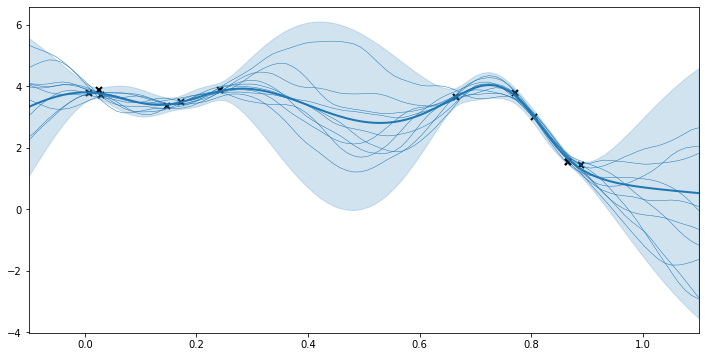

In [45]:
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1) # test points must be of shape (n, 1)

## predict mean and variance of latent at test points
mean, var = m.predict_f(xx)

## generate samples from posterior
samples = m.predict_f_samples(xx, 10)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);


GP regression in higher dimension
--

Very little changes when the input space has more than one dimension and setting the parameter `ard=True` allows tuning a different lenghscale per dimension, which is generally recommmended.

Further reading
--

Several notebooks are available to go into more details:

  - [Sparse GP regression for big data](../advanced/gps_for_big_data.ipynb) when there is a large number of observations,
  - [ordinal regression](../advanced/ordinal_regression.ipynb) if the data is ordinal,
  - [multi-outputs and coregionalisation](../advanced/coregionalisation.ipynb) if `Y` is multidimensional.